# Identification of human sequences

We'll try to replicate the [Classifying human DNA sequence and random ATCG sequences, using keras CNN](https://github.com/onceupon/deep_learning_DNA) problem, but using PyTorch instead.

In [1]:
import numpy as np
import torch.utils.data as data_utils
import torch
from torch import nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn import DataParallel
from torch import Tensor
import os

In [2]:
dataset = pd.read_csv("datasets/human-exercise/dataset.csv")
print(dataset.shape)
dataset

(20000, 2)


,sequence,label
0,CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...,1
1,CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...,1
2,AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...,1
3,AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...,1
4,ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...,1
...,...,...
19995,AAGACGAGTGGTTACCCCCTGTGAGACTGCCGCGCGTGGTGGTCGG...,0
19996,ACGAGGCCATCTAGAGCGCAACGAAACTGCAAGAAAATACGTCCGA...,0
19997,CATCTTTACCCAATTTGTGTGTGGAAAGGTGTCAGCGATGCTTTGG...,0
19998,ATAAGTAACTCCAGTCGAGCGGAAGGTATAGTGGCACGGGGTTTAG...,0


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the human DNA. The amount of positive and negative examples is evenly distributed across the two classes.

1    10000
0    10000
Name: label, dtype: int64


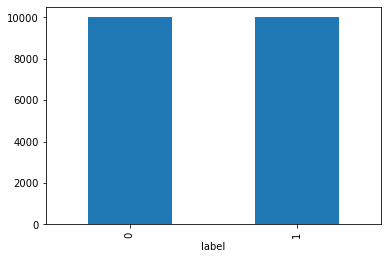

In [3]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

print(dataset['label'].value_counts())

We need now to split the dataset into training and validation sets.

In [4]:
fps_x = dataset['sequence'].values
fps_y = dataset['label'].values

# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(fps_x, fps_y, stratify=fps_y)

Now we need to one hot encode the sequences and labels.

In [5]:
import encoding as enc
X_train_enc = enc.DNAEncoding(X_train)
X_train = X_train_enc.one_hot_encode()

y_train_enc = enc.DNAEncoding(y_train)
y_train = y_train_enc.one_hot_encode()

X_test_enc = enc.DNAEncoding(X_test)
X_test = X_test_enc.one_hot_encode()

y_test_enc = enc.DNAEncoding(y_test)
y_test = y_test_enc.one_hot_encode()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 250, 4)
(15000, 2)
(5000, 250, 4)
(5000, 2)


Until this point, everything is working fine because the Keras model achieved the same accuracy as comparative study.

In [6]:
train_data = data_utils.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
train_loader = data_utils.DataLoader(train_data, shuffle=True, batch_size=16)
test_data = data_utils.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))
test_loader = data_utils.DataLoader(test_data, shuffle=True, batch_size=16)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(4, 20, 10, stride=1, padding=0)
        self.fc1 = nn.Linear(47, 10)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)

        self.max_pool = nn.MaxPool1d(10, stride=5)
    
        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.max_pool(x)
        x = self.fc1(x)
        x = self.act2(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act3(x)
        print("x:", x)
        print("x.shape:", x.shape)
        
        return x

In [8]:
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 1000 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            

def train_model(train_loader, model, epochs, device):
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            yhat = model(inputs)
            # print("yhat: ", yhat)
            # print("yhat.shape: ", yhat.shape)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch}, Loss: {loss}')
            

# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability            
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

from numpy import vstack
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix

def evaluate_model(model, device, test_loader):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        yhat = model(inputs)
        yhat = yhat.cpu().detach().numpy()
        actual = targets.cpu().numpy()
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    mcc = matthews_corrcoef(actuals, predictions)
    report = confusion_matrix(actuals, predictions)
    return acc, mcc, report

def predict(row, model):
    row = Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat

In [9]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0')
epochs = 5

model = Net()
model = DataParallel(model)
model.to(device)

# optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
# for epoch in range(1,epochs+1):
#     train(model, device, train_loader, optimizer, epoch)
#     test(model, device, test_loader)
#     scheduler.step()


train_model(train_loader, model, epochs, device)
acc, mcc, report = evaluate_model(test_loader, model, device)

print('Accuracy: %.3f' % acc)
print('MCC: %.3f' % mcc)
print(report)

x: tensor([[[0.2725, 0.0000],
         [0.3186, 0.0000],
         [0.1022, 0.0000],
         [0.1066, 0.0198],
         [0.0932, 0.0000],
         [0.3060, 0.0000],
         [0.0300, 0.0000],
         [0.2565, 0.0000],
         [0.2864, 0.0000],
         [0.1867, 0.0000],
         [0.0850, 0.0000],
         [0.0000, 0.0000],
         [0.0576, 0.0000],
         [0.2308, 0.0000],
         [0.0058, 0.0000],
         [0.4234, 0.0000],
         [0.2025, 0.0000],
         [0.3265, 0.0000],
         [0.0958, 0.0000],
         [0.0000, 0.0000]],

        [[0.2243, 0.0000],
         [0.4616, 0.0000],
         [0.0000, 0.0200],
         [0.1394, 0.0000],
         [0.0000, 0.0000],
         [0.2419, 0.0000],
         [0.4689, 0.0000],
         [0.1306, 0.0000],
         [0.3085, 0.0000],
         [0.0115, 0.0000],
         [0.0263, 0.0000],
         [0.0000, 0.0000],
         [0.0850, 0.0000],
         [0.0000, 0.0007],
         [0.3483, 0.0000],
         [0.2265, 0.0000],
         [0.0850, 0.000

ValueError: Using a target size (torch.Size([16, 2])) that is different to the input size (torch.Size([16, 20, 2])) is deprecated. Please ensure they have the same size.